In [9]:
# installing kaggle 

!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable


In [10]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
deepfake-and-real-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
import zipfile
import os

# Change 'netflix-shows.zip' to the name of your downloaded zip file.
with zipfile.ZipFile("deepfake-and-real-images.zip", 'r') as zip_ref:
    zip_ref.extractall("DEEPFAKE")  # Extract files into 'netflix_dataset' folder

# List files in the extracted folder
print(os.listdir("DEEPFAKE/Dataset"))


['Train', 'Validation', 'Test']


In [12]:
print(os.listdir("DEEPFAKE/Dataset/Train"))

['Real', 'Fake']


In [1]:
import numpy as np
import pickle
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import cv2
import os

def load_images_from_folder(folder, label, max_images=2500):
    images = []
    labels = []
    all_files = os.listdir(folder)

    # Shuffle and select a subset of files
    np.random.shuffle(all_files)
    max_images = max_images or len(all_files) // 2

    for filename in all_files[:max_images]:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        if img is not None:
            resized_img = cv2.resize(img, (128, 128))  # Resize to 128x128
            images.append(resized_img)
            labels.append(label)

    # Convert to NumPy arrays and add channel dimension
    images = np.array(images).reshape(-1, 128, 128, 1)
    labels = np.array(labels)

    return images, labels

# Load the images
real_images, real_labels = load_images_from_folder('DEEPFAKE/Dataset/Train/Real', 0)
fake_images, fake_labels = load_images_from_folder('DEEPFAKE/Dataset/Train/Fake', 1)

# Combine real and fake data
x = np.concatenate((real_images, fake_images), axis=0)
y = np.concatenate((real_labels, fake_labels), axis=0)

xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=42)

# Normalize the pixel values
xtrain = xtrain / 255.0
xtest = xtest/255.0

print(f"Training data shape: {xtrain.shape}, Labels shape: {ytrain.shape}")

Training data shape: (4000, 128, 128, 1), Labels shape: (4000,)


In [2]:
##using CNN model - Test One

from tensorflow.keras import models, layers

# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),  # Grayscale input
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [3]:

model.fit(xtrain,ytrain,validation_data=(xtest,ytest),epochs=20)

2024-10-19 16:38:11.684700: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 262144000 exceeds 10% of free system memory.


Epoch 1/20
125/125 [==============================] - 113s 897ms/step - loss: 0.6417 - accuracy: 0.6205 - val_loss: 0.6017 - val_accuracy: 0.6790
Epoch 2/20
125/125 [==============================] - 100s 802ms/step - loss: 0.5442 - accuracy: 0.7275 - val_loss: 0.5432 - val_accuracy: 0.7290
Epoch 3/20
125/125 [==============================] - 101s 808ms/step - loss: 0.4764 - accuracy: 0.7793 - val_loss: 0.4738 - val_accuracy: 0.7710
Epoch 4/20
125/125 [==============================] - 100s 800ms/step - loss: 0.4207 - accuracy: 0.8010 - val_loss: 0.4228 - val_accuracy: 0.8100
Epoch 5/20
125/125 [==============================] - 100s 797ms/step - loss: 0.3615 - accuracy: 0.8420 - val_loss: 0.4574 - val_accuracy: 0.7960
Epoch 6/20
125/125 [==============================] - 122s 976ms/step - loss: 0.3128 - accuracy: 0.8637 - val_loss: 0.4081 - val_accuracy: 0.8220
Epoch 7/20
125/125 [==============================] - 135s 1s/step - loss: 0.2697 - accuracy: 0.8857 - val_loss: 0.3768 - va

In [4]:
model.evaluate(xtest,ytest)

32/32 [==============================] - 10s 324ms/step - loss: 0.7917 - accuracy: 0.8380


[0.7917184829711914, 0.8379999995231628]

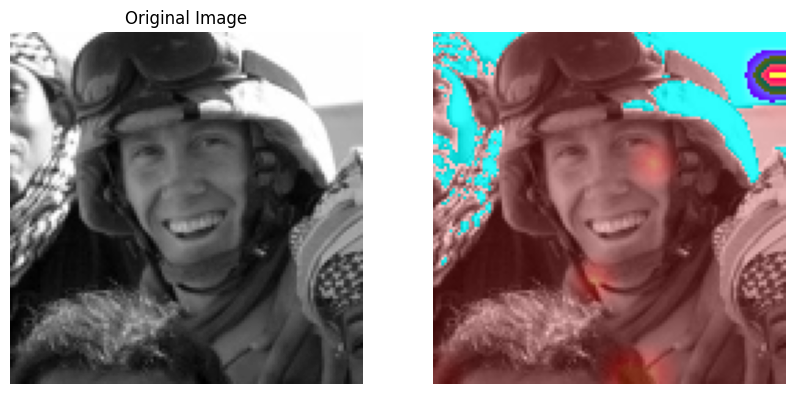

1/1 [==============================] - 0s 20ms/step
[[0.0003357]]
0


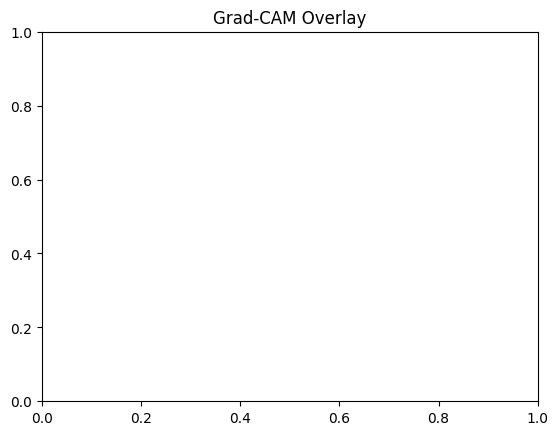

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap(model, img_array, layer_name='conv2d_3'):
    """
    Generate a Grad-CAM heatmap for the given image and model.
    Arguments:
    - model: Trained CNN model.
    - img_array: Preprocessed input image array.
    - layer_name: Name of the last convolutional layer for Grad-CAM.
    Returns:
    - heatmap: A 2D heatmap showing important regions for prediction.
    """
    # Create a model that maps input to the desired conv layer's output and predictions
    grad_model = tf.keras.models.Model(
        [model.input], 
        [model.get_layer(layer_name).output, model.output]
    )

    # Get the output feature maps and the model's prediction for the input image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # Only for the first output (binary classification)

    # Compute gradients of the predicted class with respect to the conv layer output
    grads = tape.gradient(loss, conv_outputs)

    # Pool the gradients to get the importance of each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by the pooled gradients to get weighted activation
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    
    # heatmap is already a NumPy array, so just return it
    return heatmap # Changed from heatmap.numpy() to heatmap

def display_gradcam(img, heatmap, alpha=0.4):
    """
    Superimpose the Grad-CAM heatmap on the original image.
    Arguments:
    - img: Original image.
    - heatmap: 2D Grad-CAM heatmap.
    - alpha: Opacity factor for heatmap overlay.
    """
    # Resize the heatmap to match the input image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert the grayscale image to RGB to match the heatmap's channels
    # Convert img to uint8 before applying cvtColor
    img = np.uint8(img * 255)  # Convert to 8-bit unsigned integer
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert grayscale to RGB

    # Superimpose heatmap on the original image
    superimposed_img = heatmap * alpha + img

    plt.imshow(superimposed_img.astype('uint8'))
    plt.axis('off')
    plt.show()
# Example usage:
def generate_gradcam_for_test_sample(sample_index=0):
    """
    Generate Grad-CAM visualization for a test sample.
    Arguments:
    - sample_index: Index of the test image for Grad-CAM visualization.
    """
    # Select a test image and its corresponding label
    test_image = xtest[sample_index]
    test_image_expanded = np.expand_dims(test_image, axis=0)  # Add batch dimension

    # Get Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(model, test_image_expanded, layer_name='conv2d_3')

    # Display the original image and Grad-CAM overlay
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(test_image.squeeze(), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    display_gradcam(test_image.squeeze(), heatmap)
    plt.title("Grad-CAM Overlay")

# Generate Grad-CAM visualization for the first test image
generate_gradcam_for_test_sample(5)
print(model.predict(xtest[5].reshape(1,128,128,1)))
print(ytest[5])

In [12]:
# Save the model after training
model.save("deepfake_detector_model.h5")
